In [2]:
import sys
sys.path.append("..")

In [106]:
import pandas as pd
import numpy as np
from src.mysql import mysql as mysql
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min

## Data Collection

In [54]:
df = pd.read_sql('SELECT * FROM player_stats', con=mysql.conn)

## Data Wrangling

#### Drop unwanted columns and records

In [55]:
columns_2_drop = ['3p_conv','2p_conv','free_conv','plus_minus_bal','val','foults_com']
df = df[df.year >= 2010]
df = df[df.time >= 5]
df = df[df.games >= 10].reset_index()

#### Calculate avg stats per Player

In [56]:
df_player = df.groupby(['player']).mean()
df_player = df_player.drop(columns_2_drop, axis=1).reset_index()
X = df_player.drop(['index','year','games'], axis=1)

#### Average player statistics per 20 min played

In [59]:
for col in X.columns:
    
    if col == 'free_perc' or col == '3p_perc' or col =='2p_perc' or col =='time' or col == 'player':
        pass
    else:
        X[col] = X[col] / X['time']*20
        
X = X.iloc[:,2:]

In [60]:
X.head()

,points,3p_try,3p_perc,2p_try,2p_perc,free_try,free_perc,reb_def,ref_att,reb_tot,assis,steals,turnovers,block_fav,block_con,dunks,foults_rec
0,8.571429,0.000000,0.000,5.892857,60.90,1.964286,71.400,2.678571,1.428571,4.107143,0.714286,0.535714,1.964286,0.714286,0.357143,0.714286,2.142857
1,11.426117,4.123711,40.600,5.068729,51.90,1.288660,87.900,1.632302,0.257732,1.804124,1.718213,0.687285,1.975945,0.000000,0.343643,0.000000,1.804124
2,7.142857,3.415103,43.075,1.779702,48.60,1.178451,79.575,2.260702,0.841751,3.102453,1.250601,0.673401,0.769601,0.144300,0.120250,0.024050,1.418951
3,8.328558,1.795606,39.650,4.622732,49.75,1.986628,80.250,1.910220,0.687679,2.559694,2.177650,0.840497,1.298949,0.000000,0.420248,0.038204,2.139446
4,6.310680,0.000000,0.000,5.218447,51.00,1.213592,82.400,2.063107,1.699029,3.762136,0.728155,0.242718,0.606796,0.485437,0.242718,0.242718,1.092233


## PCA

In [61]:
X.shape

(821, 17)

#### Find first n-PCs to explain 80% variance

In [63]:
data = {}
for n in range(2,17):
    pca_pipeline = make_pipeline(StandardScaler(),PCA(n))
    pca_pipeline.fit(X)
    pca = pca_pipeline.named_steps['pca']
    data[n] = pca.explained_variance_ratio_.sum()
    
pca.explained_variance_ratio_

array([0.37032624, 0.17110303, 0.09454003, 0.06808313, 0.05267047,
       0.04133708, 0.03759765, 0.03640784, 0.03280895, 0.02425973,
       0.02043244, 0.01776324, 0.01443959, 0.01113356, 0.00572001,
       0.00131924])

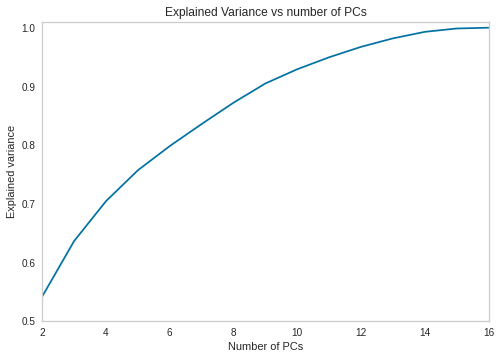

In [174]:
plt.figure()
sns.lineplot(x=list(data.keys()), y = list(data.values()))

plt.ylim(0.5,1.01)
plt.xlim(2,16)
plt.title('Explained Variance vs number of PCs')
plt.ylabel('Explained variance')
plt.xlabel('Number of PCs')
plt.grid(b=None)

plt.savefig('../img/variance.jpg', dpi = 500)
plt.show()

#### 80% explained variance reached with 6 first PCs

In [85]:
pca_pipeline = make_pipeline(StandardScaler(),PCA(6))
pca_pipeline.fit(X)
pca = pca_pipeline.named_steps['pca']

In [183]:
from pandas.plotting import table 

In [199]:
variance = [round(num, 3) for num in pca.explained_variance_ratio_]

In [244]:
df_var = pd.DataFrame(variance, columns = ['Var_exp_%'], index = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])

df_var.to_pickle('../data/PC_var')

#### Eigen vectors

In [87]:
loadings = pca.components_.T 
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3','PC4','PC5','PC6'], index=X.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6
points,0.069842,-0.407217,-0.498804,-0.033034,-0.021373,0.131849
3p_try,-0.313580,-0.077289,-0.314393,-0.028797,0.001222,-0.027702
3p_perc,-0.256065,-0.090942,-0.338144,-0.147182,0.252167,-0.169272
2p_try,0.282178,-0.260555,-0.094062,0.178938,0.119901,0.224134
2p_perc,0.209753,0.001879,-0.271056,-0.422068,-0.340920,0.326019
free_try,0.211398,-0.416855,-0.006214,0.012514,-0.107610,-0.322508
free_perc,-0.181972,-0.229115,-0.290411,-0.045855,0.097230,0.030449
reb_def,0.321485,0.062734,-0.106383,-0.183068,0.238497,-0.301204
ref_att,0.351865,0.109804,0.028670,0.069320,0.143021,-0.137337
reb_tot,0.361379,0.091275,-0.051149,-0.076970,0.214228,-0.245027


In [245]:
df_load = loading_matrix.apply(lambda x: round(x,2))

df_load.to_pickle('../data/loadings')

## KMeans Clustering

In [90]:
transformed_X = pca_pipeline.transform(X)

In [93]:
df_pc = pd.DataFrame(transformed_X, columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])

In [94]:
df_join = pd.concat([df_player,df_pc], axis = 1)

#### Find most suitable number of clusters

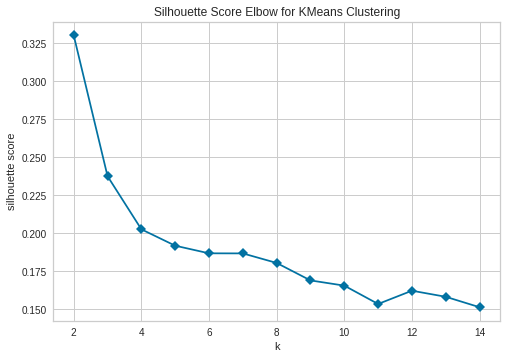

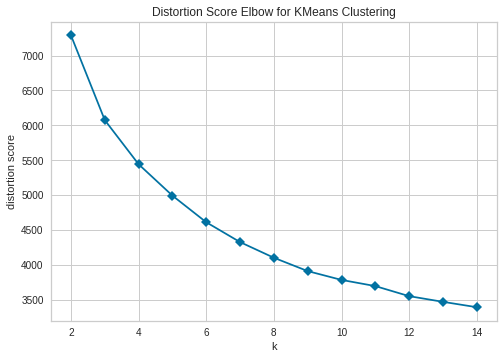

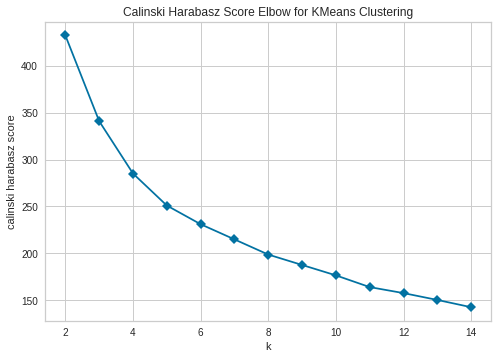

In [223]:

for parameter in ['silhouette', 'distortion', 'calinski_harabasz']:    
    model = KMeans()
    plt.figure()

    visualizer = KElbowVisualizer(
    model, k=(2,15), metric=parameter, timings=False, locate_elbow=False
    )

    visualizer.fit(transformed_X) 
    

    plt.title(f'{parameter}')
    plt.ylabel('Score')
    plt.xlabel('Number of Clusters')
    
    plt.savefig(f'../img/{parameter}.jpg', transparent=True, dpi=500)
    # Fit the data to the visualizer
    visualizer.show()

#### Optimum number of clusters  = 7 based on silhouette graph

In [114]:
k_means = KMeans(n_clusters=7, 
                 random_state=0)

k_means.fit(transformed_X)

KMeans(n_clusters=7, random_state=0)

In [115]:
df_join['cluster'] = k_means.labels_

In [116]:
df_join.head()

,player,index,year,games,time,points,3p_try,3p_perc,2p_try,2p_perc,...,block_con,dunks,foults_rec,PC1,PC2,PC3,PC4,PC5,PC6,cluster
0,AJ Ogilvy,2619.0,2011.0,26.0,11.200,4.800,0.00,0.000,3.30,60.90,...,0.200,0.400,1.200,3.574127,-0.413332,0.567071,0.074563,-1.222106,1.376928,6
1,AJ Slaughter,74.0,2019.0,22.0,23.280,13.300,4.80,40.600,5.90,51.90,...,0.400,0.000,2.100,-1.970189,-2.221737,-1.148896,0.124084,-0.092076,1.322519,4
2,Aaron Doornekamp,703.5,2017.5,35.0,20.790,7.425,3.55,43.075,1.85,48.60,...,0.125,0.025,1.475,-1.824112,1.378447,-1.000250,-0.706218,0.544875,-0.812036,2
3,Aaron Jackson,2587.0,2010.5,39.5,26.175,10.900,2.35,39.650,6.05,49.75,...,0.550,0.050,2.800,-0.885734,-1.491618,0.147892,0.130101,0.936986,0.483290,4
4,Abodunrin Gabriel Olaseni,745.0,2017.0,34.0,16.480,5.200,0.00,0.000,4.30,51.00,...,0.200,0.200,0.900,1.607003,2.240227,-0.227298,1.445095,-0.707992,0.463603,3


#### Centroids of each cluster

In [231]:
centroids = k_means.cluster_centers_
centroids

array([[-2.23064573, -0.69688931,  1.47846335, -0.5263319 , -0.04873377,
         0.22426011],
       [ 3.63382697, -1.57102342, -0.05101368,  0.18001049,  0.13026255,
        -0.31673513],
       [-2.16859328,  0.96272753, -1.20723435,  0.07820648, -0.2127826 ,
         0.07567847],
       [ 0.57195122,  0.46026882, -0.57896266, -0.12017744,  0.51801621,
        -0.20057164],
       [-1.29365259, -2.1653248 , -0.38522386,  0.24747555, -0.19512789,
         0.08777215],
       [-1.38671808,  2.42014941,  0.9647913 ,  0.61601843,  0.04362319,
        -0.45274278],
       [ 3.858376  ,  1.22233261,  0.46220391, -0.08991862, -0.44485001,
         0.42194096]])

In [235]:
centroids_df = pd.DataFrame(centroids, columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])
centroids_df.to_pickle('../data/centroids')

####  And closest players to each centroid

In [118]:
closest, _ = pairwise_distances_argmin_min(k_means.cluster_centers_, transformed_X)

In [119]:
closest

array([367, 586, 135, 368, 150, 597, 105])

#### Average stats for each cluster

In [132]:
df_mean_clus = pd.DataFrame()


for n_clus in range(0,7):
    df_cluster = df_join[df_join.cluster==n_clus].iloc[:,4:-7]
    for col in df_cluster.columns:

        if col == 'free_perc' or col == '3p_perc' or col =='2p_perc' or col =='time':
            pass
        else:
            df_cluster[col] = df_cluster[col] / df_cluster['time']*20

    df_cluster = df_cluster.iloc[:,:]
    
    df_mean_clus[f'cluster{n_clus}'] = df_cluster.mean()
    df_std_clus[f'cluster{n_clus}'] = df_cluster.std()
    
df_mean_clus.set_index(df_cluster.mean().index, inplace=True)


In [230]:
df_mean_clus.to_pickle('../data/df_mean_clus')

df_mean_clus

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
time,18.476602,18.957147,18.952171,19.244234,21.117908,12.426465,15.643762
points,6.336113,9.393090,7.794470,7.610785,9.704483,4.390955,6.935783
3p_try,2.589982,0.650189,3.821118,2.111988,3.448148,2.238810,0.179043
3p_perc,30.879289,18.239658,37.279632,32.645698,35.141643,25.990499,5.247366
2p_try,2.947749,6.142173,2.627358,4.059236,4.221105,2.387895,4.872407
2p_perc,45.111204,54.797096,49.174237,51.776433,48.316846,40.691867,57.372980
free_try,1.525817,2.973114,1.139833,1.722354,2.364767,0.947370,2.000952
free_perc,78.104290,69.281308,80.973789,73.779803,81.727289,61.554186,60.253670
reb_def,1.501081,3.121565,1.670125,2.626142,1.604869,1.829391,2.972636
ref_att,0.404730,1.735220,0.488834,1.160760,0.444272,0.806956,1.913567


In [243]:
df_join[df_join.cluster==6].player.unique()

array(['AJ Ogilvy', 'Adam Chubb', 'Adam Pechacek', 'Adrián Laso',
       'Albert Fontet', 'Albert Miralles', 'Ali Badara Traore',
       'Andrew Betts', 'Andy Ogide', 'Antanas Kavaliauskas',
       'Anzejs Pasecniks', 'Artem Pustovyi', 'Augusto Lima',
       'Ben Lammers', 'Bismack Biyombo', 'Boniface Ndong',
       'Cedric Simmons', 'Chema González', "D'Or Fischer",
       'Daniel Miller', 'Danny Agbelese', 'Dejan Borovnjak',
       'Dejan Kravic', 'Diamon Simpson', 'Dimitrios Mavroeidis',
       'Domas Sabonis', 'E. Mockevicius', 'Ebuka Izundu', 'Edy Tavares',
       'Ehimen Orukpe', 'Ekene Ibekwe', 'Emanuel Cate',
       'Emir Sulejmanovic', 'Filip Kraljevic', 'Fran Vázquez',
       'Frank Elegar', 'Georgios Bogris', 'Gerald Lee', 'Gustavo Ayón',
       'Hamady Ndiaye', 'Hasan Rizvic', 'Ilimane Diop', 'JP Tokoto',
       'James Augustine', 'Jarvis Lamar Varnado', 'Joey Dorsey',
       'Jordi Trias', 'Josip Sobin', 'Juan José García',
       'Juan José Triguero', 'Kevin Seraphin', 'K

In [164]:
df_join.to_pickle('../data/clustering_10s')

## Visualization

In [252]:
from sklearn.manifold import TSNE

In [273]:
mylabels = ['0 - Great Vision and Assist Leaders', '1 - Top Forwards', '2 - 3P Shooters', '3 - Hybrid Players','4 - Top Outside Players' ,'5 - Support Players', '6 - Pure Inside Players']

In [ ]:
ax.legend(labels=mylabels)

/home/sergio/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


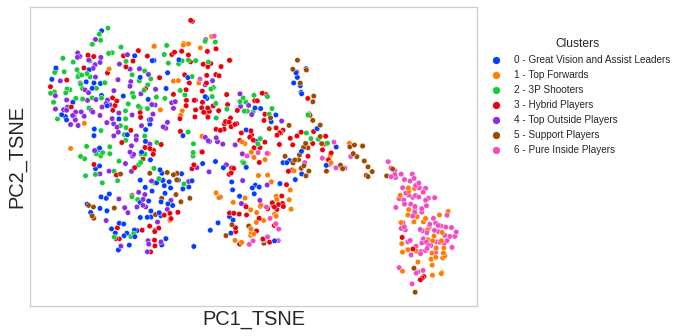

In [354]:
sns.color_palette("tab10")

tsne = TSNE(n_components=2, perplexity=50)
transformed_tsne = tsne.fit_transform(X)
data = pd.DataFrame(transformed_tsne, columns=['PC1_TSNE', 'PC2_TSNE'])

data['cluster'] = df_join['cluster']


fig, ax = plt.subplots()

sns.scatterplot('PC1_TSNE', 'PC2_TSNE', data=data, hue= 'cluster', s= 30, palette=sns.color_palette('bright', data.cluster.unique().shape[0]))
plt.xlabel('PC1_TSNE', size=20)
plt.ylabel('PC2_TSNE', size=20)

ax.set_xticks([])
ax.set_yticks([])

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, mylabels, title='Clusters', bbox_to_anchor=(1, 0.7), loc='center left')



plt.savefig(f'../img/clusters_tsne.jpg', transparent=True, dpi=800, bbox_inches='tight')
    
    
plt.show()

/home/sergio/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


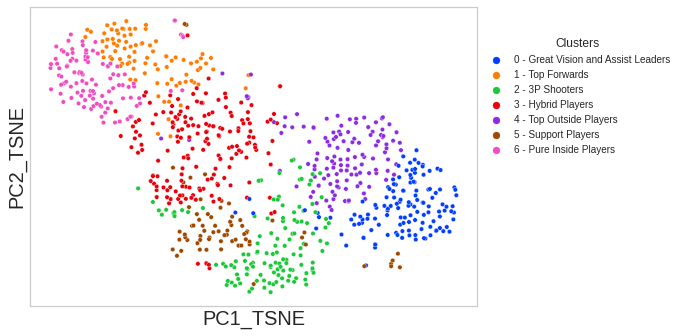

In [353]:
sns.color_palette("tab10")

tsne = TSNE(n_components=2, perplexity=50)
transformed_tsne = tsne.fit_transform(df_pc)
data = pd.DataFrame(transformed_tsne, columns=['PC1_TSNE', 'PC2_TSNE'])

data['cluster'] = df_join['cluster']

fig, ax = plt.subplots()

sns.scatterplot('PC1_TSNE', 'PC2_TSNE', data=data, hue= 'cluster', s= 20, palette=sns.color_palette('bright', data.cluster.unique().shape[0]))
plt.xlabel('PC1_TSNE', size=20)
plt.ylabel('PC2_TSNE', size=20)

ax.set_xticks([])
ax.set_yticks([])

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, mylabels, title='Clusters', bbox_to_anchor=(1, 0.7), loc='center left')


plt.savefig(f'../img/clusters__pc_tsne.jpg', transparent=True, dpi=800, bbox_inches='tight')
    
    
plt.show()

,PC1,PC2,PC3,PC4,PC5,PC6
0,3.574127,-0.413332,0.567071,0.074563,-1.222106,1.376928
1,-1.970189,-2.221737,-1.148896,0.124084,-0.092076,1.322519
2,-1.824112,1.378447,-1.000250,-0.706218,0.544875,-0.812036
3,-0.885734,-1.491618,0.147892,0.130101,0.936986,0.483290
4,1.607003,2.240227,-0.227298,1.445095,-0.707992,0.463603
...,...,...,...,...,...,...
816,-0.747717,-1.636785,-0.085925,-0.199923,0.052668,-0.564408
817,-1.759238,3.013253,-1.710343,-0.555878,-0.294964,0.034180
818,-1.784360,-1.565897,-0.043697,-0.349724,-0.014228,-0.887022
819,-2.076191,1.466141,-0.289323,1.014694,0.225797,-0.324992


In [246]:
df_join

,player,index,year,games,time,points,3p_try,3p_perc,2p_try,2p_perc,...,block_con,dunks,foults_rec,PC1,PC2,PC3,PC4,PC5,PC6,cluster
0,AJ Ogilvy,2619.000000,2011.0,26.000000,11.200000,4.800000,0.000000,0.000000,3.300000,60.900,...,0.200000,0.400000,1.200000,3.574127,-0.413332,0.567071,0.074563,-1.222106,1.376928,6
1,AJ Slaughter,74.000000,2019.0,22.000000,23.280000,13.300000,4.800000,40.600000,5.900000,51.900,...,0.400000,0.000000,2.100000,-1.970189,-2.221737,-1.148896,0.124084,-0.092076,1.322519,4
2,Aaron Doornekamp,703.500000,2017.5,35.000000,20.790000,7.425000,3.550000,43.075000,1.850000,48.600,...,0.125000,0.025000,1.475000,-1.824112,1.378447,-1.000250,-0.706218,0.544875,-0.812036,2
3,Aaron Jackson,2587.000000,2010.5,39.500000,26.175000,10.900000,2.350000,39.650000,6.050000,49.750,...,0.550000,0.050000,2.800000,-0.885734,-1.491618,0.147892,0.130101,0.936986,0.483290,4
4,Abodunrin Gabriel Olaseni,745.000000,2017.0,34.000000,16.480000,5.200000,0.000000,0.000000,4.300000,51.000,...,0.200000,0.200000,0.900000,1.607003,2.240227,-0.227298,1.445095,-0.707992,0.463603,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,Álex Mumbrú,1755.375000,2013.5,35.375000,28.038750,12.812500,4.825000,34.912500,5.862500,47.800,...,0.375000,0.050000,3.625000,-0.747717,-1.636785,-0.085925,-0.199923,0.052668,-0.564408,4
817,Álex Suárez,1190.166667,2015.5,23.166667,11.650000,3.633333,2.300000,35.183333,0.766667,58.100,...,0.066667,0.066667,0.400000,-1.759238,3.013253,-1.710343,-0.555878,-0.294964,0.034180,2
818,Álex Urtasun,1060.333333,2016.0,24.666667,16.278333,6.900000,2.383333,37.250000,2.766667,44.750,...,0.133333,0.000000,2.116667,-1.784360,-1.565897,-0.043697,-0.349724,-0.014228,-0.887022,4
819,Álvaro Muñoz,1327.750000,2015.0,25.500000,14.752500,4.575000,2.575000,31.750000,1.900000,38.975,...,0.175000,0.075000,0.950000,-2.076191,1.466141,-0.289323,1.014694,0.225797,-0.324992,2


In [247]:
df

,index,player,player_id,team,team_id,year,games,time,points,3p_conv,...,assis,steals,turnovers,block_fav,block_con,dunks,foults_com,foults_rec,plus_minus_bal,val
0,0,Nikola Mirotic,2020210,BARÇA,2,2019,25,25.85,19.0,1.4,...,1.4,1.1,1.8,0.7,0.2,0.1,2.1,5.4,7.0,22.7
1,1,Ante Tomic,2020217,BARÇA,2,2019,28,19.72,9.5,0.0,...,1.4,1.1,1.3,0.2,0.2,0.4,1.8,2.5,5.0,13.6
2,2,Brandon Davies,3000001,BARÇA,2,2019,28,18.63,11.3,0.4,...,1.0,0.9,1.7,0.4,0.1,0.8,2.8,3.9,3.0,13.1
3,3,Adam Hanga,2020983,BARÇA,2,2019,27,21.13,7.0,0.6,...,4.0,0.9,2.0,0.4,0.2,0.2,2.4,2.0,5.0,9.9
4,4,Malcolm Delaney,3000007,BARÇA,2,2019,19,22.47,10.3,1.5,...,3.6,0.7,2.3,0.1,0.2,0.1,2.9,3.6,5.0,9.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,2861,Rafa Luz,2020027,UNICAJA,14,2010,15,16.53,4.4,0.4,...,2.2,1.1,1.6,0.0,0.0,0.1,2.0,2.1,0.0,5.6
2082,2862,Saúl Blanco,2020182,UNICAJA,14,2010,29,16.80,5.3,0.8,...,1.0,0.8,0.9,0.2,0.1,0.1,1.1,0.8,0.0,4.6
2083,2863,Uros Tripkovic,2020213,UNICAJA,14,2010,34,15.27,6.5,1.4,...,1.0,0.3,0.8,0.1,0.2,0.0,2.1,0.7,0.0,3.6
2084,2864,Panchi Barrera,2020176,UNICAJA,14,2010,10,12.28,3.3,0.5,...,1.7,1.0,2.1,0.0,0.2,0.0,1.9,1.2,0.0,3.5


In [248]:
X

,points,3p_try,3p_perc,2p_try,2p_perc,free_try,free_perc,reb_def,ref_att,reb_tot,assis,steals,turnovers,block_fav,block_con,dunks,foults_rec
0,8.571429,0.000000,0.000000,5.892857,60.900,1.964286,71.400000,2.678571,1.428571,4.107143,0.714286,0.535714,1.964286,0.714286,0.357143,0.714286,2.142857
1,11.426117,4.123711,40.600000,5.068729,51.900,1.288660,87.900000,1.632302,0.257732,1.804124,1.718213,0.687285,1.975945,0.000000,0.343643,0.000000,1.804124
2,7.142857,3.415103,43.075000,1.779702,48.600,1.178451,79.575000,2.260702,0.841751,3.102453,1.250601,0.673401,0.769601,0.144300,0.120250,0.024050,1.418951
3,8.328558,1.795606,39.650000,4.622732,49.750,1.986628,80.250000,1.910220,0.687679,2.559694,2.177650,0.840497,1.298949,0.000000,0.420248,0.038204,2.139446
4,6.310680,0.000000,0.000000,5.218447,51.000,1.213592,82.400000,2.063107,1.699029,3.762136,0.728155,0.242718,0.606796,0.485437,0.242718,0.242718,1.092233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,9.139138,3.441666,34.912500,4.181713,47.800,2.023985,74.500000,2.469796,0.552806,3.013686,1.881325,0.686550,1.658419,0.089162,0.267487,0.035665,2.585707
817,6.237482,3.948498,35.183333,1.316166,58.100,0.543634,75.833333,2.260372,0.629471,2.861230,0.371960,0.486409,0.600858,0.200286,0.114449,0.114449,0.686695
818,8.477526,2.928228,37.250000,3.399201,44.750,2.539162,83.233333,1.597215,0.409542,2.006757,1.740555,0.778130,1.310535,0.020477,0.163817,0.000000,2.600594
819,6.202339,3.490934,31.750000,2.575835,38.975,0.982884,78.350000,1.762413,0.677851,2.440264,1.050669,0.474496,0.915099,0.067785,0.237248,0.101678,1.287917


In [251]:
df_join['cluster']

0      6
1      4
2      2
3      4
4      3
      ..
816    4
817    2
818    4
819    2
820    0
Name: cluster, Length: 821, dtype: int32